### Forecasting in Aquaponics

Libraries and setup

In [241]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import sys

os.environ['KMP_DUPLICATE_LIB_OK']='True'

# np.set_printoptions(threshold=sys.maxsize)

mpl.rcParams['figure.figsize'] = (14, 8)
mpl.rcParams['axes.grid'] = True

np.random.seed(10)

## Data adquisition

### Data adquisition

In [242]:
def read_file(textfile):
    df = pd.read_csv(textfile, compression='zip', sep="\t")
    df.drop(df.columns[0], axis=1, inplace=True)
    print('Dataset ready')
    return df

textfile = "dataset_aquaponics_04012021_04302021.txt.zip"
df = read_file(textfile)

Dataset ready


Organize data in columns

In [243]:

df_grouped = pd.pivot_table(df, index = 'DateTime', columns = 'Label', values = 'Value')
df_grouped.index = pd.to_datetime(df_grouped.index)

start_date = pd.to_datetime('2021-04-01 00:00:00')
end_date = pd.to_datetime('2021-04-17 23:59:59')

df_grouped = df_grouped.loc[start_date:end_date]
print(df_grouped.head)

<bound method NDFrame.head of Label                      1          2    3       4       5          6    \
DateTime                                                                    
2021-04-01 00:00:12  20.880000  51.345560  0.0  6.6498  6.6667  44.003500   
2021-04-01 00:00:38  20.822498  51.096670  0.0  6.6498  6.6667  44.007060   
2021-04-01 00:01:04  20.853998  51.175000  0.0  6.6514  6.6681  43.999874   
2021-04-01 00:05:57  20.928003  50.800000  0.0  6.6584  6.6718  43.621853   
2021-04-01 00:06:23  21.000000  50.686670  0.0  6.6596  6.6731  42.650578   
...                        ...        ...  ...     ...     ...        ...   
2021-04-17 23:57:50  21.576002  37.025555  0.0  6.6468  6.6632  50.360703   
2021-04-17 23:58:17  21.594002  36.996670  0.0  6.6468  6.6614  50.077550   
2021-04-17 23:58:42  21.614002  37.014446  0.0  6.6468  6.6614  50.475870   
2021-04-17 23:59:08  21.587502  36.866665  0.0  6.6478  6.6614  50.111244   
2021-04-17 23:59:33  21.568000  36.821114  0.0

Data visualization

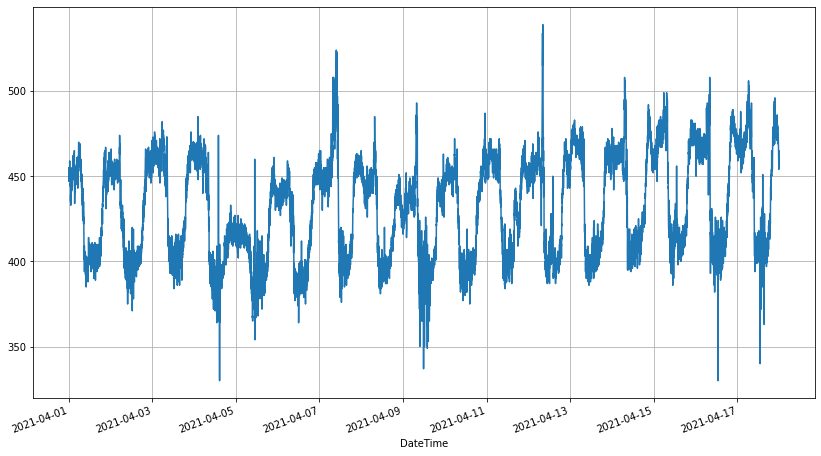

In [244]:
sample_sensor = 18

df_grouped[sample_sensor].plot(x = 'DateTime', y = 'Value', kind = 'line')
plt.xticks(rotation=20)
plt.show()

## Data Pre-processing

### Selecting target 

Target variables:

* 4     = pH sump B
* 5     = pH sump A
* 8     = % oxygen B
* 9     = % oxygen A
* 18    = C02
* 93*   = Weight cell 1
* 99*   = Nitrate B 
* 100*  = Ammonia B
* 103*  = Nitrate A 
* 104*  = Ammonia A
* sensors are not online yet*

In [245]:
label_target = {5: 'pH sump A',  
                9: '% oxygen A'}


### Select features - Human knowledge

In [246]:
drop_signal = [3, 12, 13, 14, 15, 22, 23, 24, 25, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 56, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 93, 94, 95, 97, 98, 99, 100, 101, 104, 105, 106, 111, 112, 113, 114]
df_grouped  = df_grouped.drop(columns = drop_signal)
print(df_grouped.head())

Label                      1         2       4       5          6    \
DateTime                                                              
2021-04-01 00:00:12  20.880000  51.34556  6.6498  6.6667  44.003500   
2021-04-01 00:00:38  20.822498  51.09667  6.6498  6.6667  44.007060   
2021-04-01 00:01:04  20.853998  51.17500  6.6514  6.6681  43.999874   
2021-04-01 00:05:57  20.928003  50.80000  6.6584  6.6718  43.621853   
2021-04-01 00:06:23  21.000000  50.68667  6.6596  6.6731  42.650578   

Label                      7       8       9       10      11   ...    91   \
DateTime                                                        ...          
2021-04-01 00:00:12  49.062016  99.262  95.587  11.690  13.552  ...  406.0   
2021-04-01 00:00:38  49.063637  99.262  95.587  11.690  13.552  ...  406.0   
2021-04-01 00:01:04  49.068360  99.255  95.599  11.687  13.528  ...  406.0   
2021-04-01 00:05:57  49.068610  99.289  95.774  11.615  13.512  ...  406.0   
2021-04-01 00:06:23  49.073135  99

### Denoising dataframe - FFT filter

Check sampling frecuency

In [247]:
sampling_time = df_grouped.index.to_series().diff().median()
print(sampling_time)

0 days 00:00:26


Design sample filter

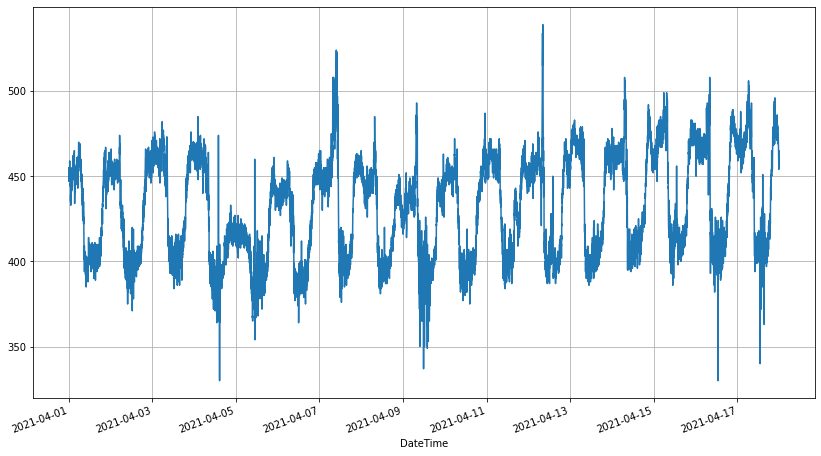

(28636, 46)


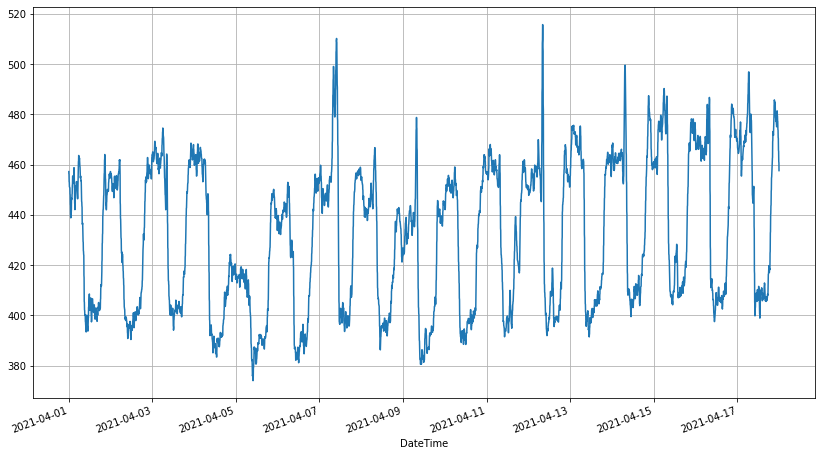

In [248]:
def f_filtering(df, cutt_fc):
    
    new_df = df.copy() 
    index = df.index
    
    dt = 25 # seconds
    n_samples = new_df.shape[0]
    
    # Fast Fourier transform
    f_hat = np.fft.fft(df.to_numpy())
    f_mag_2 = np.real(f_hat * np.conj(f_hat)) / n_samples
    fc_df = (1 / (dt * n_samples)) * np.arange(n_samples)
    
    # Cutting frecuency
    ind_filter = f_mag_2 > cutt_fc
    
    # Filter signal
    f_hat_clean = f_hat * ind_filter
    filter_signal = np.fft.ifft(f_hat_clean)
    
    
    filter_signal = np.real(filter_signal)
    
    return filter_signal

df_grouped[sample_sensor].plot(x = 'DateTime', y = 'Value', kind = 'line')
plt.xticks(rotation=20)
plt.show()

# Cutting frecuency
cutt_fc = {
1: 5,   
2: 150,     
4: 0.001,   
5: 0.005,   
6: 25,   
7: 25,   
8: 1,   
9: 1,  
10: 0.1,  
11: 0.1,  
16: 0.1,  
17: 0.1,
18: 500,  
19: 5,  
20: 20,  
21: 20, 
102: 10, 
103: 50}

df_clean = df_grouped.copy()

for sensor in cutt_fc:
    df_clean[sensor] = f_filtering(df_grouped[sensor], cutt_fc[sensor])
    
print(df_clean.shape)

df_clean[sample_sensor].plot(x = 'DateTime', y = 'Value', kind = 'line')
plt.xticks(rotation=20)
plt.show()

### Feature selection via correlation analysis

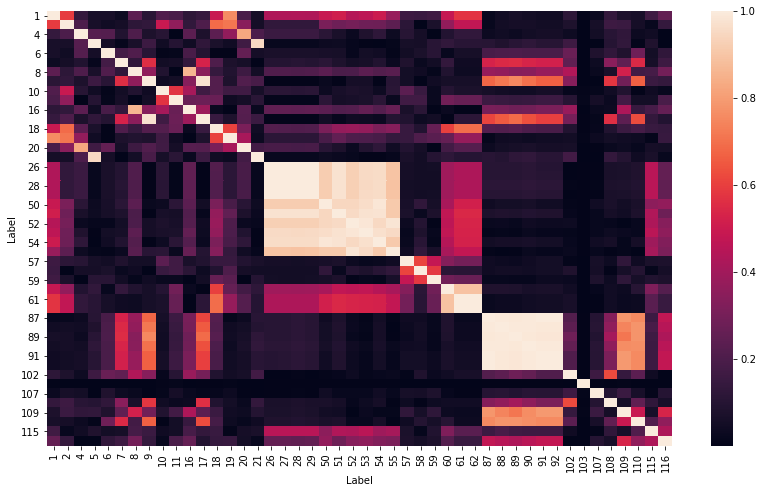

In [249]:
corr_mat = np.abs(df_clean.corr(method='pearson'))
sns.heatmap(corr_mat)
plt.show()

corr_thl = 0.25
corr_label = np.zeros(df_grouped.shape[1])

for i in label_target:
    corr_label = corr_label | (corr_mat[i] > corr_thl)

df_clean = df_clean.loc[:, corr_label]

Describe  dataset

In [250]:
print(df_clean.describe().transpose())

         count         mean        std          min          25%          50%  \
Label                                                                           
5      28636.0     6.675076   0.033121     6.328707     6.666254     6.675281   
7      28636.0    47.539641   2.906426    37.967173    45.538220    47.990785   
8      28636.0   101.171154   2.663950    94.316089    99.444032   100.770774   
9      28636.0    96.048075   4.577596    88.751129    92.966986    94.877775   
16     28636.0    10.730241   0.311862     9.811967    10.510607    10.719713   
17     28636.0    10.101525   0.500796     9.151747     9.751985     9.986074   
21     28636.0     6.610800   6.556325    -1.492146     3.409159     6.327050   
87     28636.0  1356.293721  10.510800  1339.000000  1347.000000  1356.000000   
88     28636.0   350.358535   6.128813   341.000000   345.000000   351.000000   
89     28636.0   386.400894   6.437937   377.000000   381.000000   386.000000   
90     28636.0   345.357592 

## Split dataset: train, validation and test

In [251]:
total_data = len(df_clean)

train_perc, val_perc, test_perc = 0.7, 0.2, 0.1

train_df    = df_clean[0:int(total_data*train_perc)]
val_df      = df_clean[int(total_data*train_perc):int(total_data*(train_perc + val_perc))]
test_df     = df_clean[int(total_data*(train_perc + val_perc)):total_data]

## Data normalization

Min-max normalization

In [252]:
def f_normalize_minmax(df, train_df):
    norm_df = (df - train_df.min()) / (train_df.max() - train_df.min())
    return norm_df

def f_inv_normalize_minmax(norm_df, train_df):
    df = norm_df * (train_df.max() - train_df.min()) + train_df.min()
    return df

norm_train_df   = f_normalize_minmax(train_df, train_df)
norm_val_df     = f_normalize_minmax(val_df, train_df)
norm_test_df    = f_normalize_minmax(test_df, train_df)

Show tails with box plot

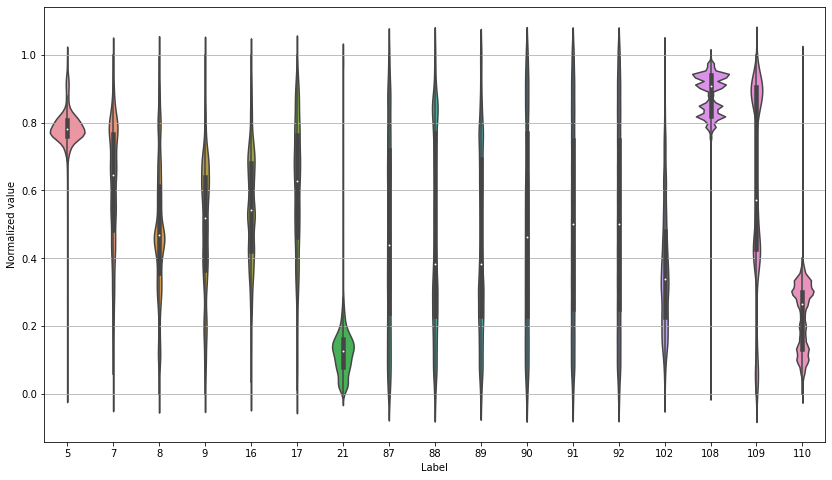

In [253]:
melt_train_df = norm_train_df.melt(var_name = 'Label', value_name = 'Normalized value')
plt.figure()
ax = sns.violinplot(x = 'Label', y = 'Normalized value', data = melt_train_df)
plt.show()

## Create input and target dataframe - Window generation

In [254]:
n_hour_data = 65 # 65 entries ~ 1 hour - There is a variable sampling frecuency
n_hours_in  = 1
n_hours_out = 1

input_width     = n_hour_data * n_hours_in 
label_width     = n_hour_data * n_hours_out 
offset_width    = 1 # 1 as default

def f_window_gen(df, label_target, input_width, label_width, offset_width):

    time_range = df.index
    data = []
    target = []

    data_time = []
    target_time = []

    for i in range(len(time_range) - (input_width + offset_width + label_width)):
        range_data = df.loc[time_range[i]:time_range[input_width + i]].values
        data.append(range_data)
        data_time.append(time_range[i:input_width + i])

        range_target = df[label_target].loc[time_range[input_width + offset_width + i: input_width + offset_width + label_width + i]].values
        target.append(range_target.flatten('C'))
        target_time.append(time_range[input_width + offset_width + i: input_width + offset_width + label_width + i])

    data = np.array(data)
    target = np.array(target)

    return data, target, data_time, target_time

train_data, train_target, train_data_time, train_target_time = f_window_gen(norm_train_df, label_target, input_width, label_width, offset_width)
val_data, val_target, val_data_time, val_target_time = f_window_gen(norm_val_df, label_target, input_width, label_width, offset_width)
test_data, test_target, test_data_time, test_target_time = f_window_gen(norm_test_df, label_target, input_width, label_width, offset_width)

Plotting - Normalized values

In [255]:
def plot_results(label_target, label_time, label, results):
    n_label = np.int(len(label_target))
    n_time = np.int(label_time.shape[0])

    m_label = label.reshape(n_time, n_label)
    m_results = results.reshape(n_time, n_label)

    sensor_tag = list(label_target.values())

    fig, ax = plt.subplots(n_label, sharex = 'all')

    for i in range(n_label):
        ax[i].plot(label_time, m_label[:, i], color = 'blue', label = 'Real')
        ax[i].plot(label_time, m_results[:, i], color = 'orange', label = 'Prediction')
        ax[i].set_ylabel(sensor_tag[i])

    lines, labels = fig.axes[-1].get_legend_handles_labels()
    fig.legend(lines, labels, loc = 'center right')
    plt.xticks(rotation=20)
    plt.xlabel('Day - Time')
    plt.show()

    pass

Plotting - History

In [256]:
def plot_history(history):

    acc = history.history['mean_absolute_error']
    val_acc = history.history['val_mean_absolute_error']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    fig, ax = plt.subplots(2, sharex = 'all')

    # Plot training and validation accuracy per epoch
    ax[0].plot(epochs, acc, label = 'Training')
    ax[0].plot(epochs, val_acc, label = 'Validation')
    ax[0].title.set_text('Training and validation MAE')

    # Plot training and validation loss per epoch
    ax[1].plot(epochs, loss, label = 'Training')
    ax[1].plot(epochs, val_loss, label = 'Validation')
    ax[1].title.set_text('Training and validation loss')

    lines, labels = fig.axes[-1].get_legend_handles_labels()
    fig.legend(lines, labels, loc = 'center right')
    plt.xticks(rotation=20)
    plt.xlabel('epochs')
    plt.show()

## Model architecture

### Linear model

In [257]:
def f_linear_model(label_target, label_width):
    linear_model = tf.keras.Sequential([
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(units = 40),
                    tf.keras.layers.Dense(units = 15),
                    tf.keras.layers.Dense(units = len(label_target) * label_width)])
    return linear_model

linear_model = f_linear_model(label_target, label_width)

### MLP model

In [258]:
def f_mlp_model(label_target, label_width):
    mlp_model = tf.keras.Sequential([
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(units = 65*10, activation = 'relu'),
                tf.keras.layers.Dense(units = 65*5, activation = 'relu'),
                tf.keras.layers.Dense(units = 65, activation = 'relu'),
                tf.keras.layers.Dense(units = len(label_target) * label_width)])
    return mlp_model
    
mlp_model = f_mlp_model(label_target, label_width)

### RNN - LSTM

In [259]:
def f_lstm_model(input_shape, output_shape):
    lstm_model = tf.keras.Sequential([
                tf.keras.layers.LSTM(units = 65 * 10, input_shape = input_shape, return_sequences=True),
                tf.keras.layers.LSTM(units = 65 * 5, return_sequences=True),
                tf.keras.layers.LSTM(units = 65 * 2),
                tf.keras.layers.Dense(output_shape)])
    return lstm_model

input_shape = train_data[0].shape
output_shape = train_target.shape[1]
lstm_model = f_lstm_model(input_shape, output_shape)

### RNN - GRU

In [260]:
def f_gru_model(input_shape, output_shape):
    lstm_model = tf.keras.Sequential([
                tf.keras.layers.GRU(units = 65 * 10, input_shape = input_shape, return_sequences=True),
                tf.keras.layers.GRU(units = 65 * 5, return_sequences=True),
                tf.keras.layers.GRU(units = 65 * 2),
                tf.keras.layers.Dense(output_shape)])
    return lstm_model

input_shape = train_data[0].shape
output_shape = train_target.shape[1]
gru_model = f_gru_model(input_shape, output_shape)

## Deployment

Callbacks

In [261]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.9

Training method

In [262]:
def compile_and_fit(model, train_data, train_target, val_data, val_target, test_data, test_target, max_epochs, batch_size, test_entry):

    # Add callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                  patience = 4)
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
    callbacks = [early_stop, lr_scheduler]

    # Model compile
    model.compile(loss      = tf.losses.MeanSquaredError(),
                  optimizer = tf.optimizers.Adam(),
                  metrics   = [tf.metrics.MeanAbsoluteError()])

    # Model fit
    history = model.fit(train_data,
                        train_target,
                        batch_size = batch_size,
                        epochs  = max_epochs,
                        verbose = 2,
                        shuffle = False, 
                        validation_data = (val_data, val_target),
                        callbacks = callbacks)

    model.evaluate(test_data, test_target)

    test_data = np.reshape(test_data[test_entry], (1, test_data[0].shape[0], test_data[0].shape[1]))
    test_prediction = model.predict(test_data)
    
    test_prediction = test_prediction.reshape(label_width, len(label_target))

    plot_results(label_target, test_target_time[test_entry], test_target[test_entry], test_prediction)

    plot_history(history)

    return history, test_prediction

max_epochs = 15
batch_size = 36
test_entry = np.random.randint(0, 100)

## Linear model evaluation


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/15
554/554 - 1s - loss: 0.0495 - mean_absolute_error: 0.1441 - val_loss: 0.7301 - val_mean_absolute_error: 0.6284

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/15
554/554 - 1s - loss: 0.0262 - mean_absolute_error: 0.1108 - val_loss: 0.5448 - val_mean_absolute_error: 0.5710

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/15
554/554 - 1s - loss: 0.0166 - mean_absolute_error: 0.0899 - val_loss: 0.4119 - val_mean_absolute_error: 0.5201

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/15
554/554 - 1s - loss: 0.0137 - mean_absolute_error: 0.0836 - val_loss: 0.3214 - val_mean_absolute_error: 0.4857

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 5/15
554/554 - 1s - loss: 0.0102 - mean_absolute_error: 0.0735 - val_loss: 0.3542

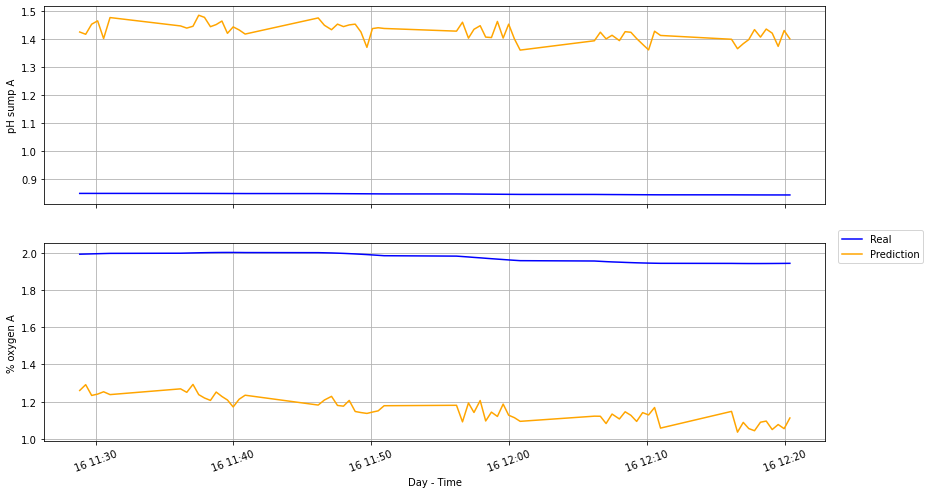

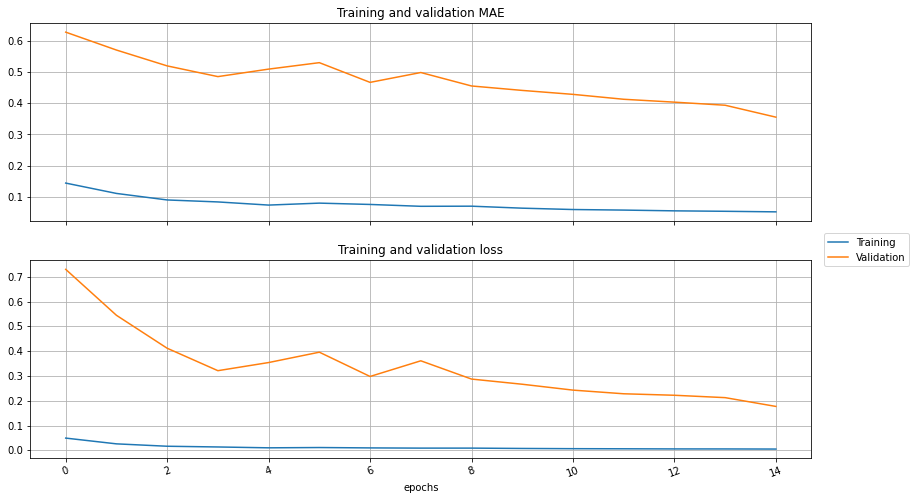

In [263]:
linear_history, linear_prediction = compile_and_fit(linear_model, train_data, train_target, val_data, val_target, test_data, test_target, 
                                                    max_epochs, batch_size, test_entry)

## MLP model evaluation


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/15
554/554 - 2s - loss: 0.0247 - mean_absolute_error: 0.0948 - val_loss: 0.3650 - val_mean_absolute_error: 0.4491

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/15
554/554 - 2s - loss: 0.0145 - mean_absolute_error: 0.0853 - val_loss: 0.3955 - val_mean_absolute_error: 0.4298

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/15
554/554 - 2s - loss: 0.0145 - mean_absolute_error: 0.0834 - val_loss: 0.4496 - val_mean_absolute_error: 0.4797

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/15
554/554 - 2s - loss: 0.0187 - mean_absolute_error: 0.0927 - val_loss: 0.3211 - val_mean_absolute_error: 0.3638

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 5/15
554/554 - 2s - loss: 0.0133 - mean_absolute_error: 0.0823 - val_loss: 0.2819

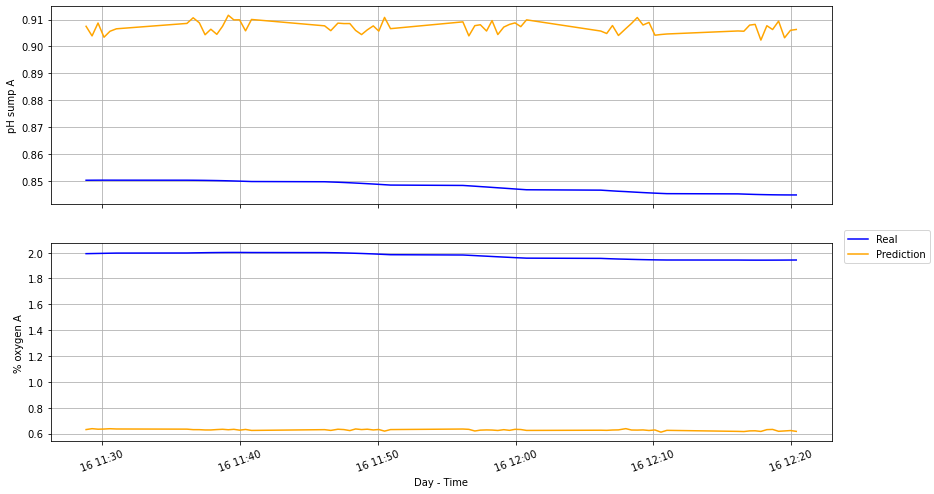

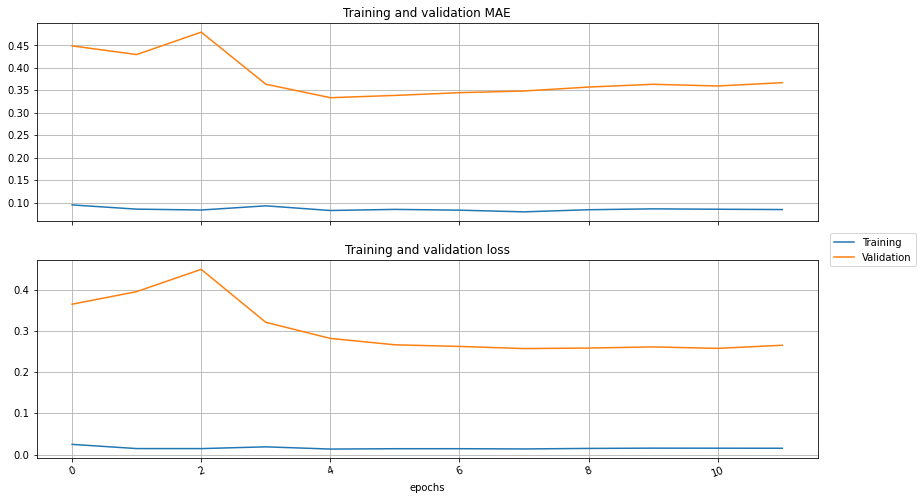

In [264]:
mlp_history, mlp_prediction = compile_and_fit(mlp_model, train_data, train_target, val_data, val_target, test_data, test_target, 
                                                    max_epochs, batch_size, test_entry)

## LSTM RNN model evaluation

In [ ]:
lstm_history, lstm_prediction = compile_and_fit(lstm_model, train_data, train_target, val_data, val_target, test_data, test_target, 
                                                    max_epochs, batch_size, test_entry)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/15


## GRU RNN model evaluation

In [ ]:
gru_history, gru_prediction = compile_and_fit(gru_model, train_data, train_target, val_data, val_target, test_data, test_target, 
                                                    max_epochs, batch_size, test_entry)